# Fraud Detection using MLM

## Import needed libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [4]:
# Loading dataset
financial = pd.read_csv('Synthetic_Financial_datasets_log.csv')

In [5]:
# checking the shape of the dataset
financial.shape

(6362620, 11)

In [6]:
# checking datatypes
financial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
# checking for null values
financial.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
# checking value counts for isFraud and isFlaggedFraud
financial_target_fraud = financial['isFraud']
financial_target_fraud.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

C:\Users\johnn\AppData\Local\Temp\ipykernel_11820\3711434388.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=financial, x='isFraud', palette='magma')


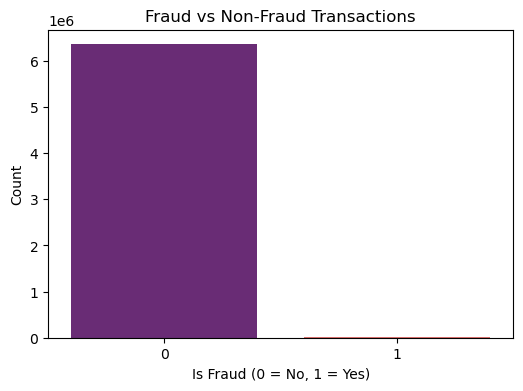

In [10]:
# Creating a countplot to visualize class imbalance
plt.figure(figsize=(6, 4))
sns.countplot(data=financial, x='isFraud', palette='magma')
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Is Fraud (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

C:\Users\johnn\AppData\Local\Temp\ipykernel_11820\235520321.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=financial, x='isFraud', y='amount', palette='Set2')


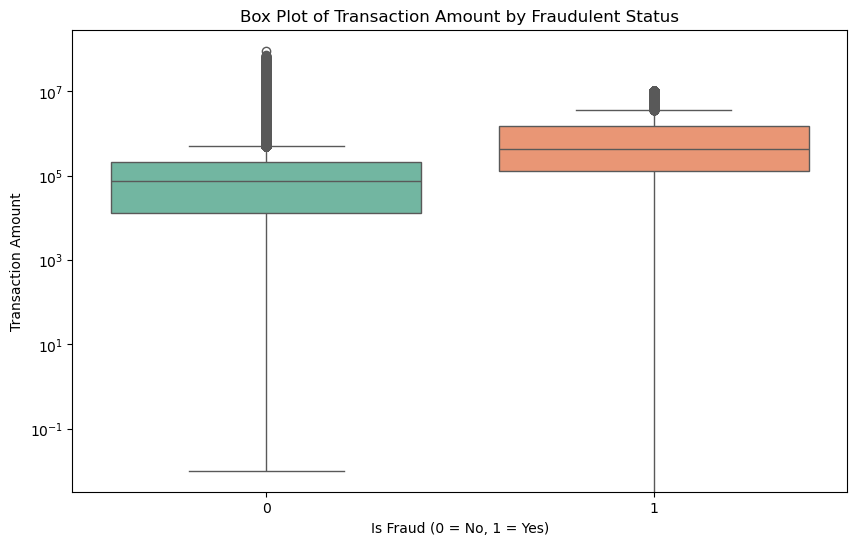

In [11]:
# Creating a boxplot to visualize transaction amount by fraudulent status
plt.figure(figsize=(10, 6))
sns.boxplot(data=financial, x='isFraud', y='amount', palette='Set2')
plt.title("Box Plot of Transaction Amount by Fraudulent Status")
plt.xlabel("Is Fraud (0 = No, 1 = Yes)")
plt.ylabel("Transaction Amount")
plt.yscale('log')  # Log scale to handle any extreme values in 'amount'
plt.show()

C:\Users\johnn\AppData\Local\Temp\ipykernel_11820\2454258713.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=financial, x='type', palette='viridis')


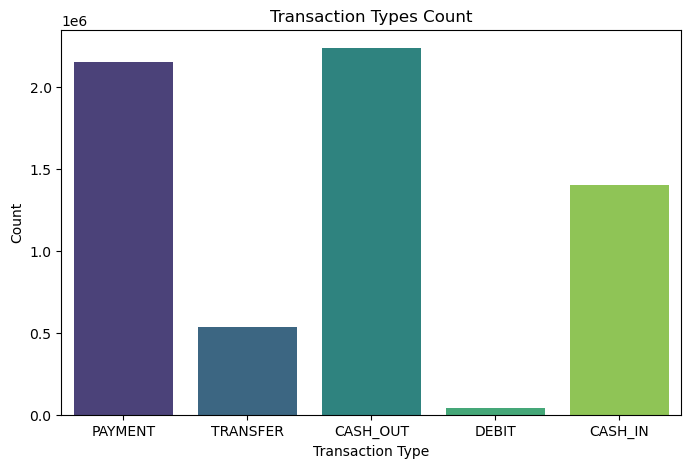

In [12]:
# creating a countplot to visualize number of transactions per type
plt.figure(figsize=(8, 5))
sns.countplot(data=financial, x='type', palette='viridis')
plt.title("Transaction Types Count")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

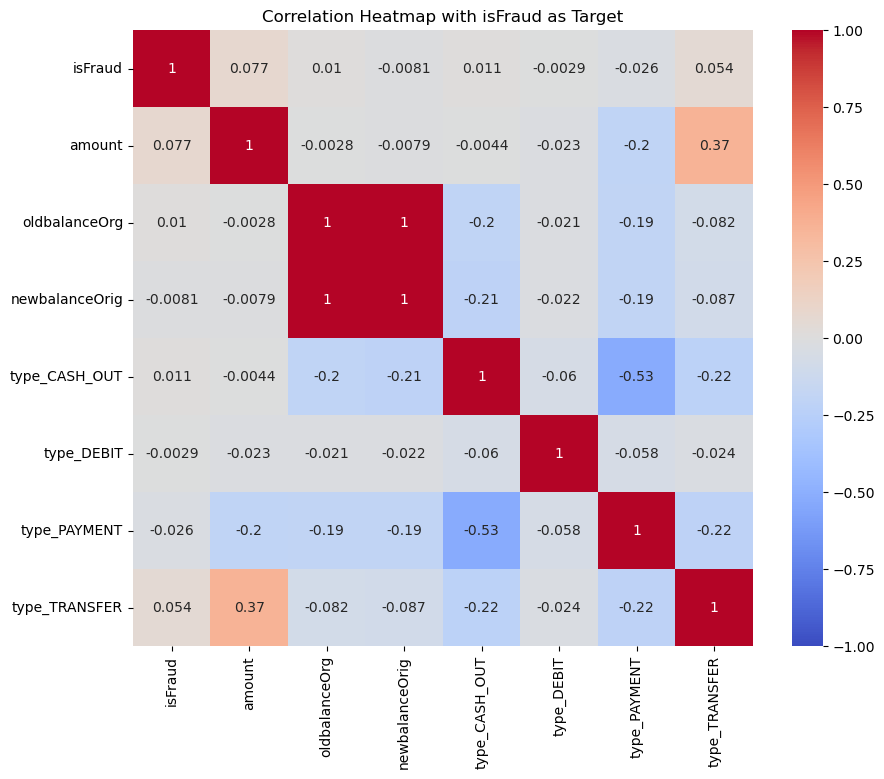

In [13]:
# Encode the 'type' feature as dummy variables (one-hot encoding)
df_encoded = pd.get_dummies(financial, columns=['type'], drop_first=True)

# Select only the relevant columns for correlation
features = ['isFraud', 'amount', 'oldbalanceOrg', 'newbalanceOrig'] + \
           [col for col in df_encoded.columns if col.startswith('type_')]
correlation_matrix = df_encoded[features].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap with isFraud as Target")
plt.show()

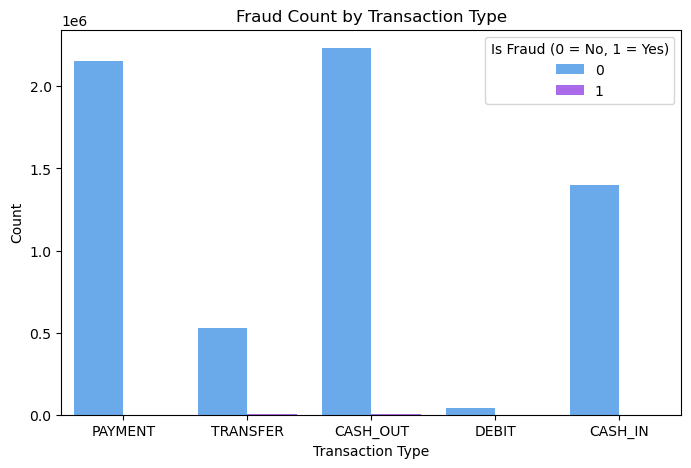

In [14]:
# Creating a countplot to visualize number of fraud cases by transaction type
plt.figure(figsize=(8, 5))
sns.countplot(data=financial, x='type', hue='isFraud', palette='cool')
plt.title("Fraud Count by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.legend(title="Is Fraud (0 = No, 1 = Yes)")
plt.show()

In [15]:
# importing required libraries
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# instantiating predictor features as X and target as y
X = financial.drop(columns=['isFraud'])
y = financial['isFraud']

# instantiating which features are categorical and which are numerical
categorical_features = ['type']
numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig']

# instantiating transformers
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first') 
numerical_transformer = StandardScaler()

# instantiating preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

# instantiating pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# transforming X features
X_transformed = pipeline.fit_transform(X)

feature_names = (pipeline.named_steps['preprocessor']
                 .transformers_[0][1]  # Access OneHotEncoder step
                 .get_feature_names_out(categorical_features).tolist()
                 + numerical_features)

X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

# importing pickle so that we can save the custom column transformer for the streamlit script
import pickle
with open('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Define the target sample size for each class
majority_target_size = 100000  # Downsample majority class to 100,000
minority_target_size = 100000  # Target for minority class after SMOTE

# Create a sampling pipeline
sampling_pipeline = ImbPipeline([
    ('under', RandomUnderSampler(sampling_strategy={0: majority_target_size})),  # Undersample majority class to 100,000
    ('over', SMOTE(sampling_strategy={1: minority_target_size}))  # Oversample minority class to 100,000
])

# Apply the pipeline
X_resampled, y_resampled = sampling_pipeline.fit_resample(X_transformed_df, y)


In [17]:
# checking the shape of X_resampled
X_resampled.shape

(200000, 7)

In [18]:
# checking the value counts to ensure we have an equivalent match of 0 and 1
y_resampled.value_counts()

isFraud
0    100000
1    100000
Name: count, dtype: int64

In [19]:
from sklearn.model_selection import train_test_split

# creating train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# defining custom function to evaluate the metrics of each model
def evaluate_model(y_true, y_pred, y_proba):
    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculating evaluation metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    
    # Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    # displaying metrics in a neat form
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC Score: {auc:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print("="*50)


In [21]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg.predict(X_test)
y_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]  # For ROC-AUC

# Evaluate the model
print("Logistic Regression Evaluation:")
evaluate_model(y_test, y_pred_log_reg, y_proba_log_reg)


Logistic Regression Evaluation:
Precision: 0.9451
Recall: 0.9331
F1-Score: 0.9391
ROC-AUC Score: 0.9887
False Positive Rate (FPR): 0.0542
False Negative Rate (FNR): 0.0669


In [22]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]  # For ROC-AUC

# Evaluate the model
print("Random Forest Evaluation:")
evaluate_model(y_test, y_pred_rf, y_proba_rf)


Random Forest Evaluation:
Precision: 0.9964
Recall: 0.9966
F1-Score: 0.9965
ROC-AUC Score: 0.9988
False Positive Rate (FPR): 0.0037
False Negative Rate (FNR): 0.0034


In [23]:
from xgboost import XGBClassifier

# Initialize and train the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]  # For ROC-AUC

# Evaluate the model
print("XGBoost Evaluation:")
evaluate_model(y_test, y_pred_xgb, y_proba_xgb)


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:17:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Evaluation:
Precision: 0.9964
Recall: 0.9966
F1-Score: 0.9965
ROC-AUC Score: 0.9996
False Positive Rate (FPR): 0.0036
False Negative Rate (FNR): 0.0034


In [24]:
from sklearn.ensemble import IsolationForest

# Initialize and train the model
iso_forest = IsolationForest(contamination=0.5, random_state=42)  # Adjust contamination if needed
iso_forest.fit(X_train)

# Predict anomalies (-1 indicates anomaly, 1 indicates normal in Isolation Forest)
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]  # Convert to match 'isFraud' label format

# Since Isolation Forest doesn’t provide probability scores, ROC-AUC won’t be applicable here
print("Isolation Forest Evaluation:")
evaluate_model(y_test, y_pred_iso, y_pred_iso)  # Using `y_pred_iso` in place of probability


Isolation Forest Evaluation:
Precision: 0.4645
Recall: 0.4613
F1-Score: 0.4629
ROC-AUC Score: 0.4646
False Positive Rate (FPR): 0.5321
False Negative Rate (FNR): 0.5387


In [25]:
from sklearn.metrics import make_scorer


# Custom scoring function for cross-validation
def custom_scorer(y_true, y_pred, y_proba):
    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # False Positive Rate (FPR) and False Negative Rate (FNR)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    # Metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    
    return {"precision": precision, "recall": recall, "f1_score": f1, "roc_auc": auc, "fpr": fpr, "fnr": fnr}

# Wrap the function to work as a scoring object for `RandomizedSearchCV`
scoring = {
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}


C:\Users\johnn\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [26]:
from sklearn.model_selection import RandomizedSearchCV


# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],  # Reduced number of trees
    'max_depth': [10, 20],  # Limited depth of trees
    'min_samples_split': [2, 5],  # Lower values to prevent deep trees
    'min_samples_leaf': [1, 2],  # Smaller leaf nodes
    'bootstrap': [True, False]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV with cross-validation
rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    n_iter=10,  # Reduced the number of iterations for the search
    scoring='roc_auc',  # Use ROC-AUC as the metric for refitting the best model
    refit='roc_auc',  # Refitting using the best model based on ROC-AUC
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    return_train_score=True
)

# Fit the RandomizedSearchCV
rf_random_search.fit(X_train, y_train)

# Best parameters and evaluation of the tuned Random Forest model
best_rf = rf_random_search.best_estimator_
print("Best parameters for Random Forest:", rf_random_search.best_params_)

# Predict and evaluate
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_rf, y_proba_rf)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  15.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  16.6s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  16.1s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  15.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  16.5s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  11.5s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  11.5s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  11.6

In [27]:
# Define a parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100],  
    'learning_rate': [0.05, 0.1],  
    'max_depth': [3, 5],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0]  
}

# Initialize XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Initialize RandomizedSearchCV for XGBoost
xgb_random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid_xgb,
    n_iter=10,  
    scoring=scoring,
    refit='roc_auc',  # Use ROC-AUC for refitting the best model
    cv=3,  
    verbose=2,
    random_state=42,
    return_train_score=True
)

# Fit RandomizedSearchCV for XGBoost
xgb_random_search.fit(X_train, y_train)

# Best parameters and evaluation of the tuned XGBoost model
best_xgb = xgb_random_search.best_estimator_
print("Best parameters for XGBoost:", xgb_random_search.best_params_)

# Predict and evaluate
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_xgb, y_proba_xgb)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.2s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.2s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.2s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.4s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.3s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.3s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.4s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.4s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.4s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.2s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.3s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.2s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s


C:\Users\johnn\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:26:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Precision: 0.9909
Recall: 0.9967
F1-Score: 0.9938
ROC-AUC Score: 0.9994
False Positive Rate (FPR): 0.0092
False Negative Rate (FNR): 0.0033


In [28]:
import joblib

# Save the best model
joblib.dump(best_xgb, "xgboost_model.pkl")

['xgboost_model.pkl']